In [5]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst_efd_client import EfdClient
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Select data from a given date
dayObs_march = 20230717
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs_march)

# Get lists of slew and track events
march_slews = [e for e in events if e.type==TMAState.SLEWING]
march_tracks = [e for e in events if e.type==TMAState.TRACKING]


In [7]:
client = makeEfdClient()

In [8]:
df_mtmount_el=getEfdData(client,'lsst.sal.MTMount.elevation', 
                         begin=march_tracks[0].begin,
                         end=march_tracks[-1].end)


In [9]:
#df_mtmount_el["times"]=Time(df_mtmount_el["private_efdStamp"], format="unix")


In [42]:
sel_upward=(df_mtmount_el["private_efdStamp"] < Time(datetime(2020,3,1)).unix)
sel_downward=(df_mtmount_el["private_efdStamp"] < Time(datetime(2020,3,1)).unix)
sel_az=(df_mtmount_el["private_efdStamp"] < Time(datetime(2020,3,1)).unix)
elevation=[]
time=[]
torque=[]
starttime=datetime(2023,7,18,7,47)
endtime=datetime(2023,7,18,9,0)#datetime(2023,7,18,11,4)
#datetime(2023,7,18,1,12)
for event in march_tracks:
    if (event.begin.datetime > starttime) & (event.end.datetime < endtime): 
        sel_event=(df_mtmount_el["private_efdStamp"] > event.begin.unix + 3 )
        sel_event&=(df_mtmount_el["private_efdStamp"] < event.end.unix - 3)
        if sel_event.sum() > 0:
            start_pos=df_mtmount_el["actualPosition"][sel_event].values[0]
            end_pos=df_mtmount_el["actualPosition"][sel_event].values[-1]
            elevation.append(start_pos)
            time.append(event.begin.datetime)
            torque.append(df_mtmount_el["actualTorque"][sel_event].max())
            if start_pos > end_pos:
                sel_downward |= sel_event
            elif start_pos < end_pos:
                sel_upward |= sel_event
            elif start_pos == end_pos:
                sel_az |= sel_event
            else: 
                print("idk")

In [43]:
print(sel_upward.sum()/len(sel_upward),
sel_downward.sum()/len(sel_downward) )

0.06401538677298499 0.0


Text(0.5, 1.0, 'Tracking events on 20230717\nAll plotted tracks are upward (end elevation > begin)')

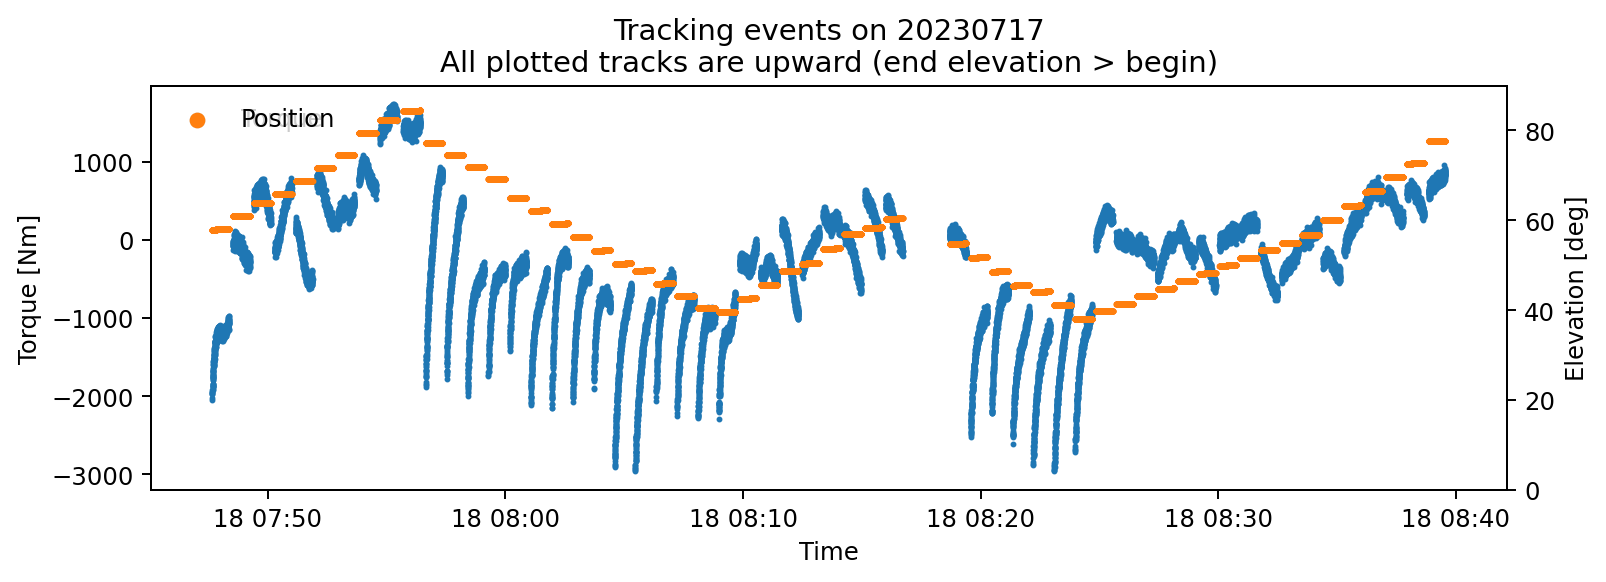

In [44]:
fig, axs=plt.subplots(1,dpi=175, figsize=(10,3))
ax=axs
ax.scatter(Time(df_mtmount_el["private_efdStamp"][sel_upward], format="unix").datetime,
            df_mtmount_el["actualTorque"][sel_upward], s=2, label="Torque")
legend=ax.legend(loc=2,edgecolor="None")
legend.legendHandles[0]._sizes=[30]
ax.set_xlabel("Time")
ax.set_ylabel("Torque [Nm]")
ax2=ax.twinx()
ax2.scatter(Time(df_mtmount_el["private_efdStamp"][sel_upward], format="unix").datetime,
            df_mtmount_el["actualPosition"][sel_upward], s=2, color="Tab:orange", label="Position")
legend=ax2.legend(edgecolor="None")
legend.legendHandles[0]._sizes=[30]
ax2.set_ylim(0,90)
ax2.set_ylabel("Elevation [deg]")
ax.set_title(f"Tracking events on {dayObs_march}\nAll plotted tracks are upward (end elevation > begin)")
# plt.scatter(df_mtmount_el["actualPosition"][sel_downward],
#             df_mtmount_el["actualTorque"][sel_downward], s=0.1)

In [122]:
ax.scatter(Time(df_mtmount_el["private_efdStamp"][sel_upward], format="unix").datetime,
            df_mtmount_el["actualTorque"][sel_upward], s=2, label="Torque")

array([ 2.62437499e+03,  2.55707373e+03,  2.48977247e+03,  2.42247120e+03,
        2.35516994e+03,  2.28786868e+03,  2.22056741e+03,  2.15326615e+03,
        2.08596489e+03,  2.01866363e+03,  1.95136236e+03,  1.88406110e+03,
        1.81675984e+03,  1.74945857e+03,  1.68215731e+03,  1.61485605e+03,
        1.54755478e+03,  1.48025352e+03,  1.41295226e+03,  1.34565099e+03,
        1.27834973e+03,  1.21104847e+03,  1.14374721e+03,  1.07644594e+03,
        1.00914468e+03,  9.41843416e+02,  8.74542153e+02,  8.07240890e+02,
        7.39939627e+02,  6.72638364e+02,  6.05337101e+02,  5.38035837e+02,
        4.70734574e+02,  4.03433311e+02,  3.36132048e+02,  2.68830785e+02,
        2.01529522e+02,  1.34228259e+02,  6.69269958e+01, -3.74267260e-01,
       -6.76755303e+01, -1.34976793e+02, -2.02278057e+02, -2.69579320e+02,
       -3.36880583e+02, -4.04181846e+02, -4.71483109e+02, -5.38784372e+02,
       -6.06085635e+02, -6.73386898e+02])

Text(0.5, 1.0, 'Tracking events on 20230328\nAll plotted tracks are upward (end elevation > begin)')

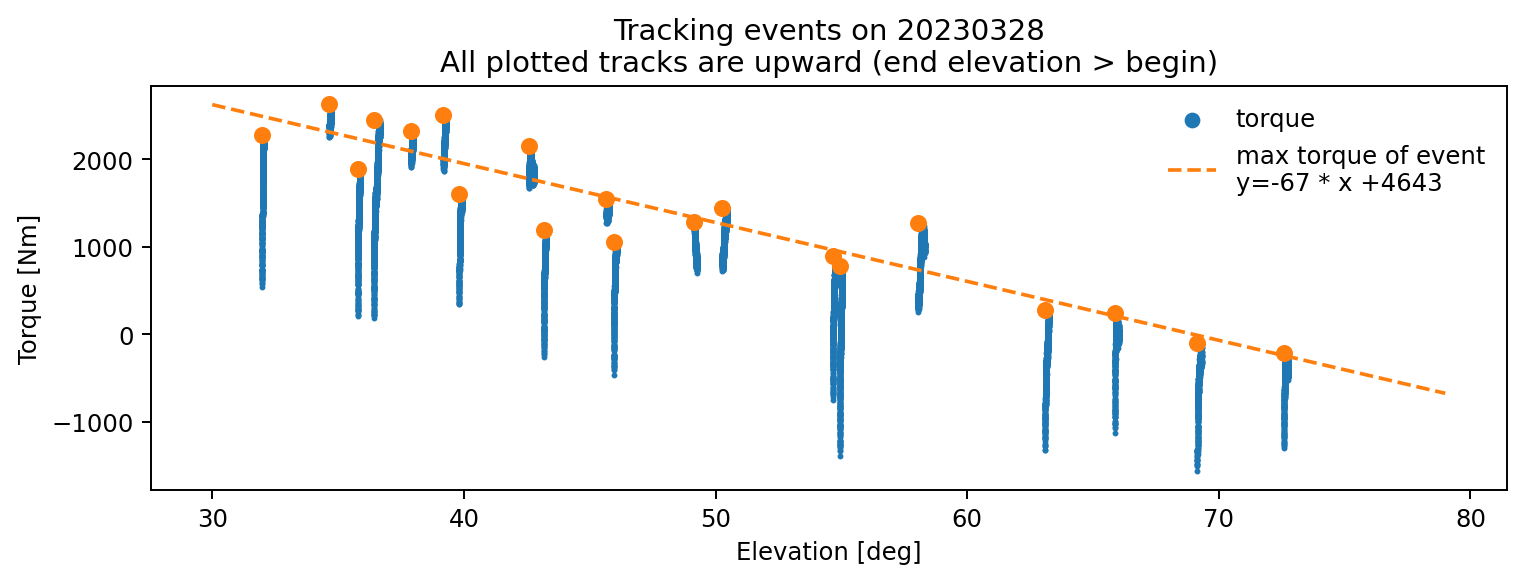

In [130]:
fig, axs=plt.subplots(1,dpi=175, figsize=(10,3))
ax=axs

fit=np.polyfit(elevation,torque, deg=1)


ax.scatter(df_mtmount_el["actualPosition"][sel_upward],
            df_mtmount_el["actualTorque"][sel_upward], s=2, label="torque")
ax.scatter(elevation, torque)
ax.plot(np.arange(30,80), np.polyval(fit,np.arange(30,80)), ls="dashed", c="tab:orange",
        label=f"max torque of event\ny={fit[0]:0.0f} * x +{fit[1]:0.0f}" )
legend=ax.legend(loc=0,edgecolor="None")
legend.legendHandles[0]._sizes=[30]
ax.set_xlabel("Elevation [deg]")
ax.set_ylabel("Torque [Nm]")
ax.set_title("Tracking events on 20230328\nAll plotted tracks are upward (end elevation > begin)")


Text(0.5, 1.0, 'Tracking events on 20230328\nAll plotted tracks are upward (end elevation > begin)')

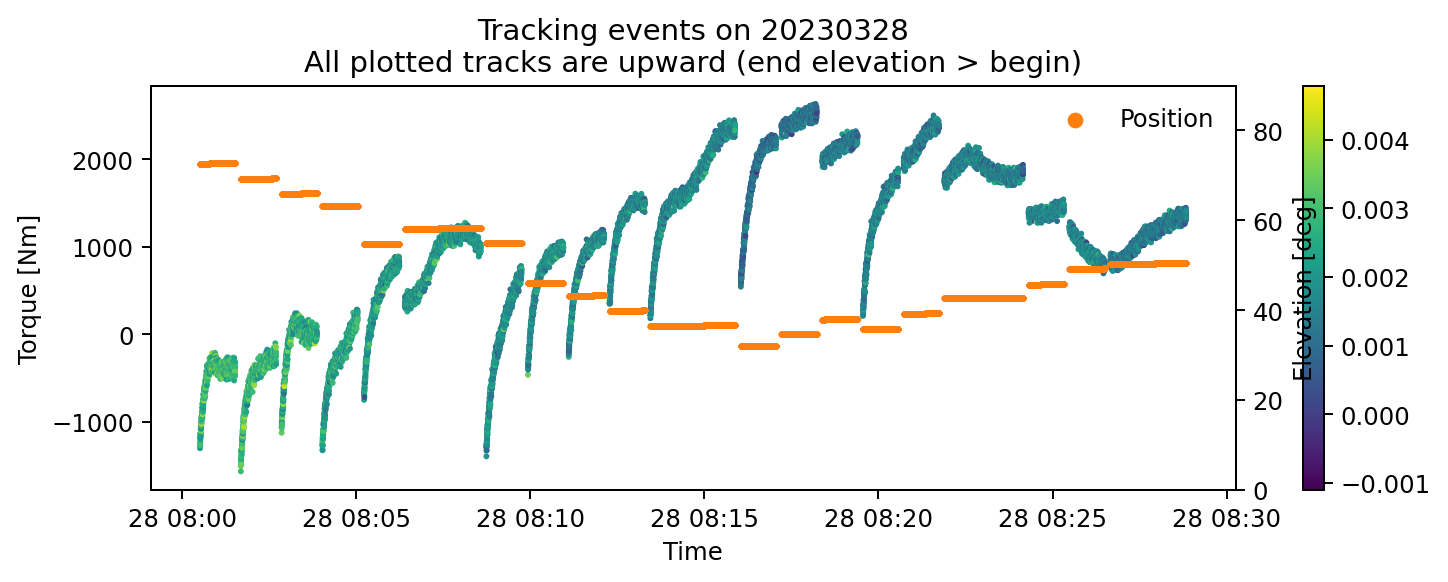

In [141]:
fig, axs=plt.subplots(1,dpi=175, figsize=(10,3))
ax=axs
sc=ax.scatter(Time(df_mtmount_el["private_efdStamp"][sel_upward], format="unix").datetime,
           df_mtmount_el["actualTorque"][sel_upward], s=2, label="Torque",
           c=df_mtmount_el["actualVelocity"][sel_upward]
          )
plt.colorbar(sc)
ax.set_xlabel("Time")
ax.set_ylabel("Torque [Nm]")
ax2=ax.twinx()
ax2.scatter(Time(df_mtmount_el["private_efdStamp"][sel_upward], format="unix").datetime,
            df_mtmount_el["actualPosition"][sel_upward], s=2, color="Tab:orange", label="Position")
legend=ax2.legend(edgecolor="None")
legend.legendHandles[0]._sizes=[30]
ax2.set_ylim(0,90)
ax2.set_ylabel("Elevation [deg]")
ax.set_title("Tracking events on 20230328\nAll plotted tracks are upward (end elevation > begin)")
# plt.scatter(df_mtmount_el["actualPosition"][sel_downward],
#             df_mtmount_el["actualTorque"][sel_downward], s=0.1)

In [ ]:
 * 60 * 60, vmax=0.005 * 3600, vmin=-0.001 * 3600

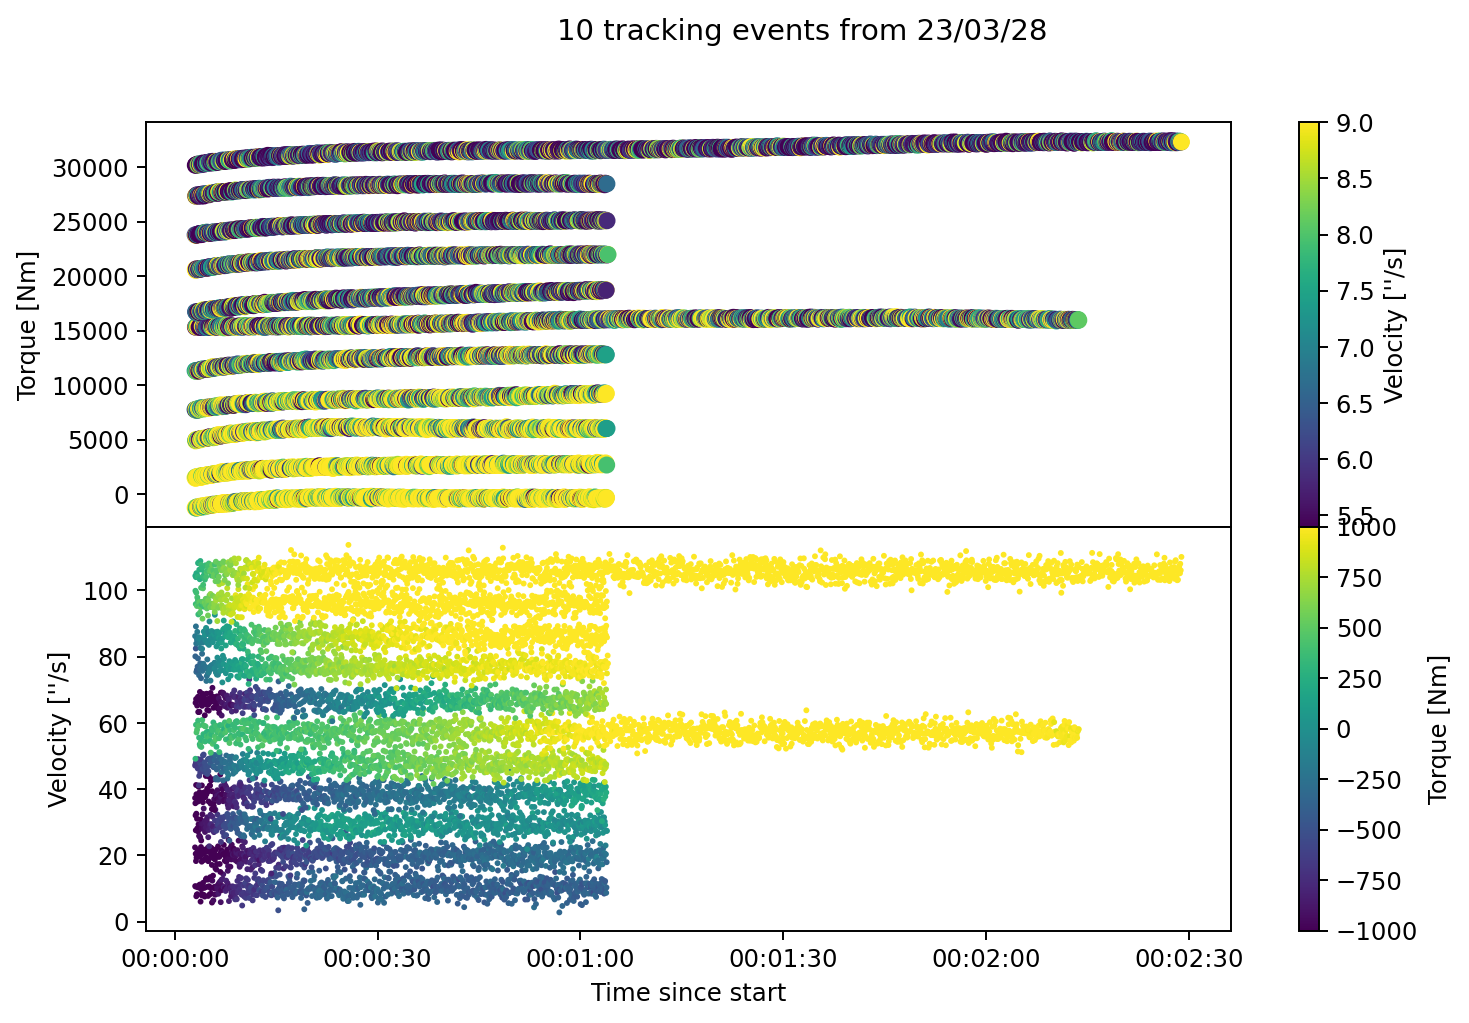

In [179]:
fig, axs=plt.subplots(2,dpi=175, figsize=(10,6),sharex=True)
ax=axs[0]
offset=0
nlines=0
plt.suptitle("10 tracking events from 23/03/28")
for event in march_tracks:
    if nlines > 10:
        continue
    if (event.begin.datetime > datetime(2023,3,28,8,0)) & (event.end.datetime < datetime(2023,3,28,8,30)): 
        sel_event=(df_mtmount_el["private_efdStamp"] > event.begin.unix + 3 )
        sel_event&=(df_mtmount_el["private_efdStamp"] < event.end.unix - 3)
        if sel_event.sum() > 0:
            start_pos=df_mtmount_el["actualPosition"][sel_event].values[0]
            end_pos=df_mtmount_el["actualPosition"][sel_event].values[-1]
        sc=ax.scatter(Time(df_mtmount_el["private_efdStamp"][sel_event] - event.begin.unix, format="unix").datetime,
                      df_mtmount_el["actualTorque"][sel_event]+ offset * 3e3, 
           c=df_mtmount_el["actualVelocity"][sel_event]*3600, vmin=1.5e-3*3600, vmax=2.5e-3*3600
          )
        nlines+=1
        offset+=1
    
plt.colorbar(sc, label="Velocity [''/s]")

ax.set_ylabel("Torque [Nm]")

ax=axs[1]
offset=0
nlines=0
for event in march_tracks:
    if nlines > 10:
        continue
    if (event.begin.datetime > datetime(2023,3,28,8,0)) & (event.end.datetime < datetime(2023,3,28,8,30)): 
        sel_event=(df_mtmount_el["private_efdStamp"] > event.begin.unix + 3 )
        sel_event&=(df_mtmount_el["private_efdStamp"] < event.end.unix - 3)
        if sel_event.sum() > 0:
            start_pos=df_mtmount_el["actualPosition"][sel_event].values[0]
            end_pos=df_mtmount_el["actualPosition"][sel_event].values[-1]
        sc=ax.scatter(Time(df_mtmount_el["private_efdStamp"][sel_event] - event.begin.unix, format="unix").datetime,
                      df_mtmount_el["actualVelocity"][sel_event]*3600 + offset * 10, 
                      s=2, label="Torque",
           c=df_mtmount_el["actualTorque"][sel_event], vmin=-1e3, vmax=1e3
          )
        nlines+=1
        offset+=1
ax.set_xlabel("Time since start")
ax.set_ylabel("Velocity [''/s]")
plt.colorbar(sc, label="Torque [Nm]")
plt.subplots_adjust(hspace=0)